In [1]:
import nideconv
from nideconv import simulate
import matplotlib.pyplot as plt

Here we simulate some data that resembles the design of Failing et al. (2021)

In [2]:
conditions = [{'name':'plus_type1_exemplar1',
  'mu_group':1,
  'std_group':0.1},
  {'name':'plus_type1_exemplar2',
  'mu_group':1.1,
  'std_group':0.1},
  {'name':'plus_type2_exemplar1',
  'mu_group':1.2,
  'std_group':0.1},
  {'name':'plus_type2_exemplar2',
  'mu_group':1.3,
  'std_group':0.1},
  {'name':'drop_type1_exemplar1',
  'mu_group':.5,
  'std_group':0.1},
  {'name':'drop_type1_exemplar2',
  'mu_group':.5,
  'std_group':0.1},
  {'name':'drop_type2_exemplar1',
  'mu_group':.5,
  'std_group':0.1},
  {'name':'drop_type2_exemplar2',
  'mu_group':.5,
  'std_group':0.1}]

In [3]:
data, onsets, parameters = simulate.simulate_fmri_experiment(conditions, n_rois=2, run_duration=300*4, noise_level=.1)
data.columns = ['voxel 1', 'voxel 2']

Now, we use `ResponseFitter` to fit a Fourier basis set to all 8 conditions

In [4]:
fitter = nideconv.ResponseFitter(data, 1.0, )
for condition in conditions:
    fitter.add_event(condition['name'], onsets.loc[condition['name'], 'onset'],
                    interval=[0, 20], basis_set='fourier', n_regressors=6)
    
fitter.fit()

/Users/gdehol/git/nideconv/nideconv/regressors.py:298: UserWarning: Number of fourier regressors has to be uneven and has automatically been set to 7 per covariate
  warnings.warn('Number of {} regressors has to be uneven and has automatically '


### Subtraction approach

The simplest thing we can do is just subtract the timecourses of the two conditions...

First get a DataFrame with all the timecourses...


In [5]:
tc = fitter.get_timecourses(oversample=5)
tc.head()

voxel 1   voxel 2
event type           covariate time                    
plus_type1_exemplar1 intercept 0.0  -0.064338 -0.063203
                               0.2  -0.054490 -0.056210
                               0.4  -0.041468 -0.045870
                               0.6  -0.024803 -0.031646
                               0.8  -0.004090 -0.013066

... and then subtract the two conditions from each other. We see that the result has changed...

In [6]:
tc_plus_type1_exemplar1_corrected = tc.loc['plus_type1_exemplar1'] - tc.loc['drop_type1_exemplar1'] 

Indeed, we see that the resulting HRF is lower, because the "visual stimulation"-part of the activation is removed.

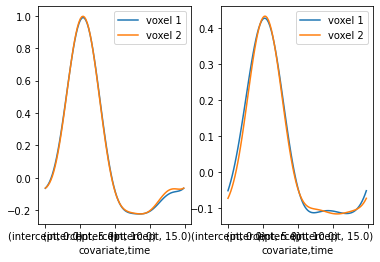

In [7]:
col1 = plt.subplot(121)
tc.loc['plus_type1_exemplar1'].plot(ax=col1)

col2 = plt.subplot(122)
tc_plus_type1_exemplar1_corrected.plot(ax=col2)

plt.gcf().set_size_inches(6, 4)

This function implements a simple t-test, where the timecourse of `condition2` is subtracted from timecourse of `condition1`. Crucially, the variance and covariance of the two estimates is taken into account, using:

$$\text{SEM} = \sqrt{c (X^TX)^{-1}\sigma^2}$$

In [8]:
import numpy as np
import pandas as pd

def paired_t_test(self, condition1, condition2):
    
    bf = self.get_basis_functions()
    c = bf.loc[condition1] - bf.loc[condition2]
    
    X_ = np.linalg.pinv(self.X.T.dot(self.X))
    sem = np.sqrt(
        (c.values.dot(X_) * c).sum(1).values[:, np.newaxis] * self.sigma2[np.newaxis, :])
    
    c_dot_beta = c.dot(self.betas)
    
    sem = pd.DataFrame(sem, index=c.index, columns=self.sigma2.index)
    
    return c_dot_beta / sem

In [9]:
t = paired_t_test(fitter, 'plus_type1_exemplar1', 'drop_type1_exemplar1')

<ipython-input-8-b5ff1c127f84>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (c.values.dot(X_) * c).sum(1).values[:, np.newaxis] * self.sigma2[np.newaxis, :])


For this very high quality data, the resulting t-values are very high (30).

<AxesSubplot:xlabel='covariate,time'>

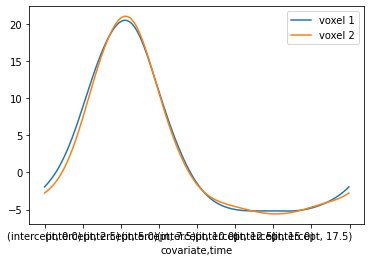

In [10]:
t.plot()

If we simulate noisier data with the same underlying parameters...

/Users/gdehol/git/nideconv/nideconv/regressors.py:298: UserWarning: Number of fourier regressors has to be uneven and has automatically been set to 7 per covariate
  warnings.warn('Number of {} regressors has to be uneven and has automatically '


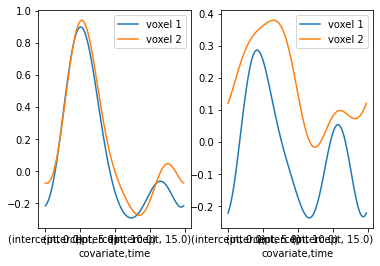

In [11]:
data, onsets, parameters = simulate.simulate_fmri_experiment(conditions, n_rois=2, run_duration=300*4, noise_level=.65)
data.columns = ['voxel 1', 'voxel 2']

fitter = nideconv.ResponseFitter(data, 1.0, )
for condition in conditions:
    fitter.add_event(condition['name'], onsets.loc[condition['name'], 'onset'],
                    interval=[0, 20], basis_set='fourier', n_regressors=6)
    
fitter.fit()

tc = fitter.get_timecourses(oversample=5)

tc_plus_type1_exemplar1_corrected = tc.loc['plus_type1_exemplar1'] - tc.loc['drop_type1_exemplar1'] 

col1 = plt.subplot(121)
tc.loc['plus_type1_exemplar1'].plot(ax=col1)

col2 = plt.subplot(122)
tc_plus_type1_exemplar1_corrected.plot(ax=col2)

plt.gcf().set_size_inches(6, 4)

the differenc eof the percent signal change stays similar (1. vs .6), but the t-values are lower:

<ipython-input-8-b5ff1c127f84>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (c.values.dot(X_) * c).sum(1).values[:, np.newaxis] * self.sigma2[np.newaxis, :])


<AxesSubplot:xlabel='covariate,time'>

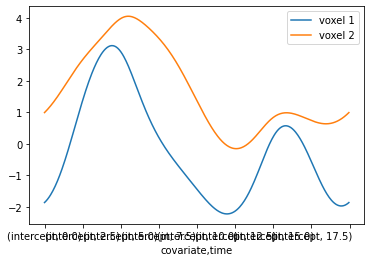

In [12]:
t = paired_t_test(fitter, 'plus_type1_exemplar1', 'drop_type1_exemplar1')
t.plot()